In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/tmp/ipykernel_201/1068843438.py:17: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [2]:
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append(pixel[0] / 256)

np_test_image_final = np.array(test_image_final)

np_test_image = np_test_image_final.reshape((4,4))
print(np_test_image)


[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


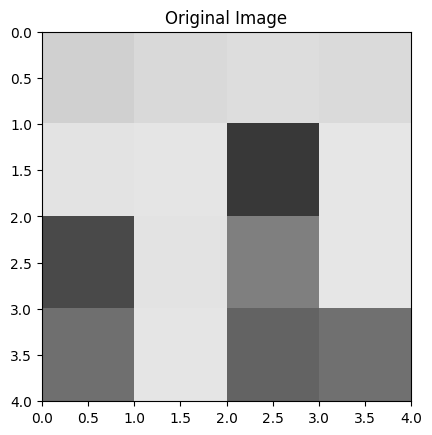

In [3]:
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


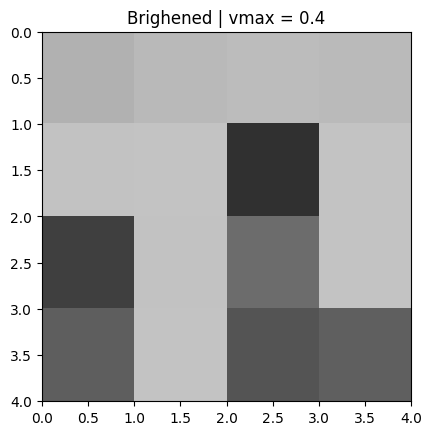

In [4]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def plot_image4x4_bright(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.4, cmap='gray')
    plt.show()
    
np_test_image_normalized = normalize(np_test_image.reshape((1,16)))
np_test_image_normalized = np_test_image_normalized.reshape((4,4))

print(np_test_image_normalized)

plot_image4x4_bright(np_test_image_normalized, "Brighened | vmax = 0.4")   

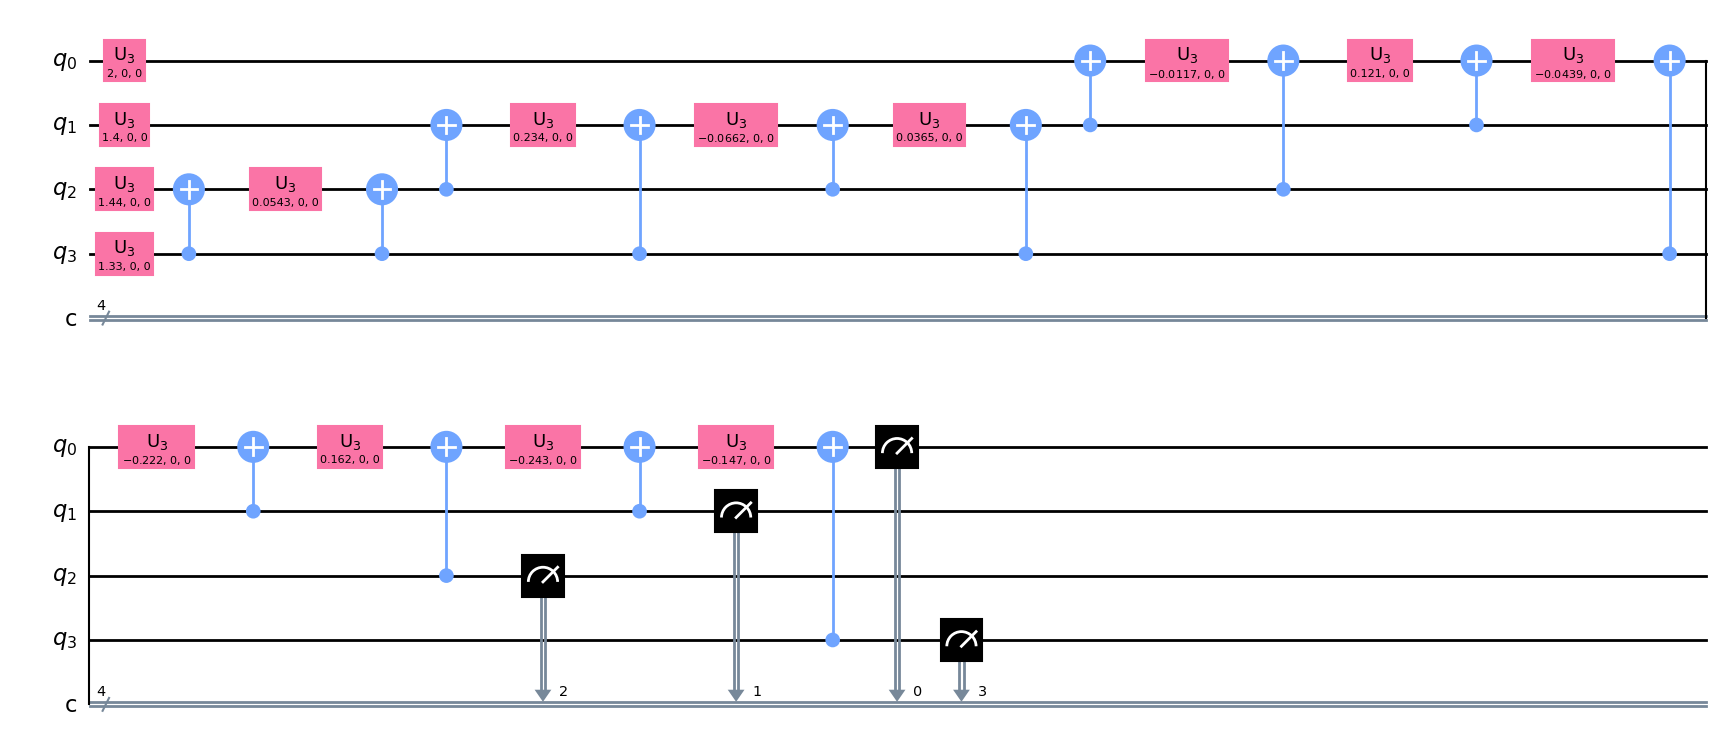

In [5]:
qc_initialize = QuantumCircuit(4,4)
qc_initialize.initialize(np_test_image_normalized.reshape(16), [0,1,2,3])


qc_initialize.measure([0,1,2,3], [0,1,2,3])
qc_initialize = qiskit.compiler.transpile(qc_initialize, basis_gates=["u1", "u2", "u3", "cx"])

qc_initialize.draw()

In [6]:
simulator = Aer.get_backend('aer_simulator')
qc_initialize_transpiled = transpile(qc_initialize, simulator)

result = simulator.run(qc_initialize_transpiled).result()
counts = result.get_counts()

print(counts)

{'0110': 7, '1000': 8, '1110': 18, '1010': 32, '1011': 90, '0011': 87, '0111': 104, '1101': 89, '1100': 31, '0000': 91, '0010': 81, '0001': 104, '1111': 20, '1001': 93, '0101': 92, '0100': 77}


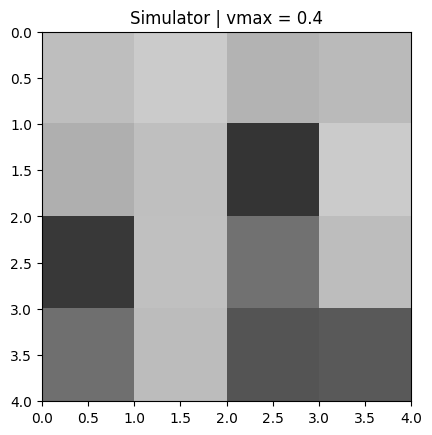

In [7]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

simulator_output = []
for i in range(16):
    if get_bin(i, 4) in counts:
        simulator_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 4000 ) ) )
    else:
        simulator_output.append(0)
        
np_simulator_output = np.array(simulator_output).reshape((4,4))
np_simulator_output = normalize(np_simulator_output)

plot_image4x4_bright(np_simulator_output, "Simulator | vmax = 0.4")   

In [8]:
def ansatz(param, num_layers):    
    num_q = 4
    qc = QuantumCircuit(num_q, num_q)    
    for j in range(num_layers):        
        for i in range(num_q):
            qc.ry(param[i + j*num_q], i)        
        if j < num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.cx(3,0)
    qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

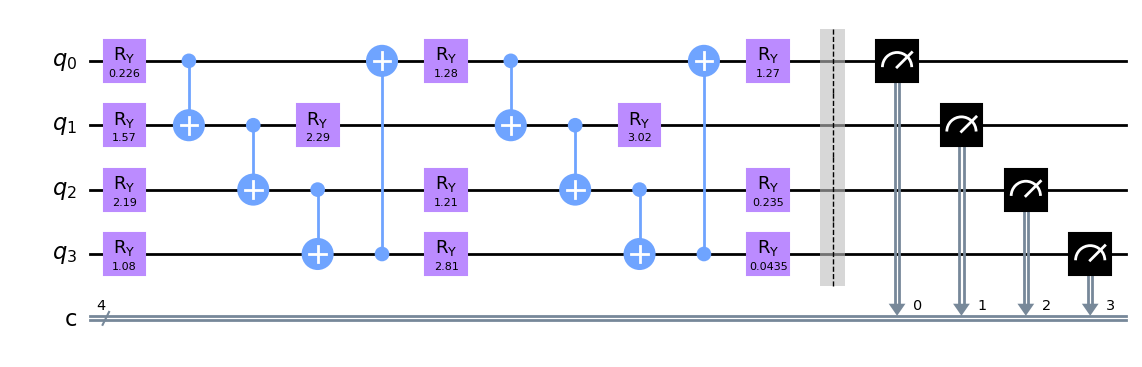

In [9]:
ansatz(param = np.random.uniform(0, np.pi, 16), num_layers=3).draw('mpl',fold=-1)

In [10]:
num_layers = 3
def loss_function(params):
    
    num_shots=16000
    circ = ansatz(param=params, num_layers=num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for i in range(16):
        strings.append(get_bin(i,4))
    
    for i in strings:
        if i not in counts:
            counts[i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    
    return sum([(p[i] - np_test_image_normalized[i])**2 for i in range(len(np_test_image_normalized))])
    #return sum([abs(p[i] - prob_distr[i]) for i in range(len(prob_distr))])
    #return sum([ prob_distr[i]*math.log2(p[i]) for i in range(len(prob_distr))])

In [11]:
# Training the Quantum Circuit
import scipy.optimize as spo

In [16]:
np_test_image_normalized = np_test_image_normalized.reshape(16)

res = spo.minimize(loss_function, np.ones(4 * num_layers), args=(), method="COBYLA")

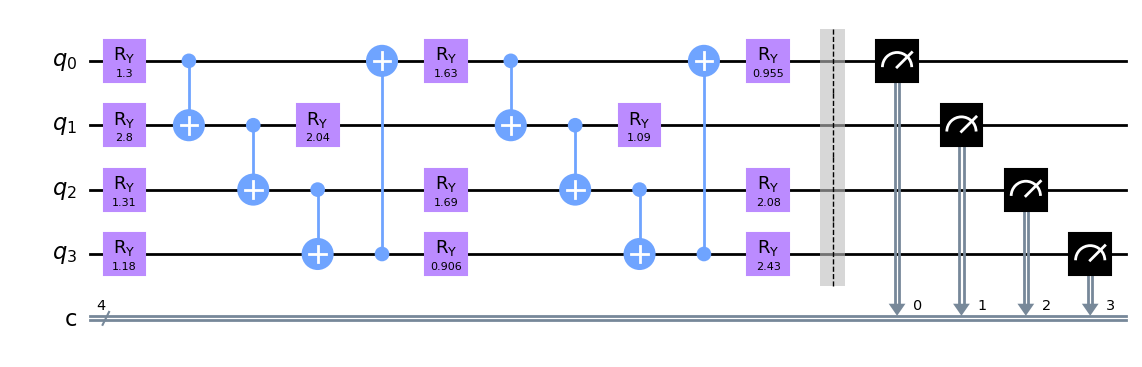

In [17]:
optimized_params = res.x

trained_ansatz = ansatz(optimized_params, num_layers)

trained_ansatz.draw()

In [18]:
simulator = Aer.get_backend('aer_simulator')
trained_ansatz_transpiled = transpile(trained_ansatz, simulator)

# Run and get statevector
result = simulator.run(trained_ansatz_transpiled).result()
counts = result.get_counts()

print(counts)

{'1000': 1, '0000': 91, '0010': 104, '1101': 110, '0011': 74, '0111': 117, '1011': 120, '1110': 6, '0100': 96, '0101': 98, '1001': 91, '1100': 2, '0001': 105, '1111': 9}


[[0.298106   0.32021721 0.31868872 0.26882266]
 [0.30618622 0.30935922 0.         0.33802043]
 [0.03125    0.298106   0.         0.3423266 ]
 [0.04419417 0.32775277 0.07654655 0.09375   ]]


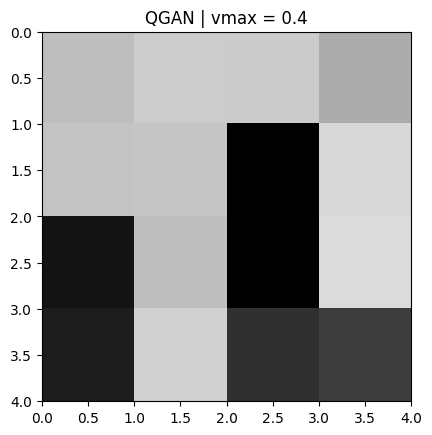

In [19]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

qGAN_output = []
for i in range(16):
    if get_bin(i, 4) in counts:
        qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 16000 ) ) )
    else:
        qGAN_output.append(0)
        
np_qGAN_output = np.array(qGAN_output).reshape((4,4))
np_qGAN_output = normalize(np_qGAN_output)

print(np_qGAN_output)

plot_image4x4_bright(np_qGAN_output, "QGAN | vmax = 0.4")   

In [6]:
import numpy as np

qgan_values = [[0.298106, 0.37238673, 0.3576726, 0.19008633],
 [0.28811076, 0.36577187, 0.03125,    0.28811076],
 [0.03125,    0.32173844, 0.03125,    0.28641098],
 [0.06987712, 0.30618622, 0,         0.14657549]]
qgan_values_np = np.array(qgan_values).reshape((1,16))
print(qgan_values_np)

[[0.298106, 0.37238673, 0.3576726, 0.19008633], [0.28811076, 0.36577187, 0.03125, 0.28811076], [0.03125, 0.32173844, 0.03125, 0.28641098], [0.06987712, 0.30618622, 0, 0.14657549]]
[[0.298106   0.37238673 0.3576726  0.19008633 0.28811076 0.36577187
  0.03125    0.28811076 0.03125    0.32173844 0.03125    0.28641098
  0.06987712 0.30618622 0.         0.14657549]]


In [25]:
# Let's run this circuit on actual quantum hardware

# Running on Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend('ibmq_kolkata')
print("Chosen Backend: ", backend_kolkata)

print("backend: ", backend_kolkata)
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_ansatz_circ = transpile(trained_ansatz, backend_kolkata, optimization_level=3)
job = backend_kolkata.run(transpiled_ansatz_circ)
job_monitor(job, interval=2)

ibmqfactory.load_account:WARNING:2023-11-23 12:36:43,944: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_kolkata
backend:  ibmq_kolkata
Job Status: job has successfully run


In [7]:
real_values = [[0.2778443,  0.2898664,  0.29520956, 0.29120219],
 [0.3032243,  0.30589588, 0.07614002, 0.30723167],
 [0.09884845, 0.30456009, 0.16964532, 0.30723167],
 [0.14827268, 0.30589588, 0.1322432,  0.14960847]]
real_values_np = np.array(real_values).reshape((1,16))
print(real_values_np)

[[0.2778443  0.2898664  0.29520956 0.29120219 0.3032243  0.30589588
  0.07614002 0.30723167 0.09884845 0.30456009 0.16964532 0.30723167
  0.14827268 0.30589588 0.1322432  0.14960847]]
